In [30]:
# 1. ALL NECESSARY IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# If CatBoost is not installed, uncomment:
# !pip install catboost
from catboost import CatBoostRegressor, Pool

plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option("display.max_columns", 50)


ModuleNotFoundError: No module named 'catboost'

In [ ]:
! pip install catboost

In [ ]:
# 3. DATA PREPROCESSING / CLEANING

# Aggregate to daily total Units
train_ts_df = (
    train_df
    .groupby("Date", as_index=False)["Units"]
    .sum()
    .sort_values("Date")
)

# Daily index with all days present
daily = train_ts_df.set_index("Date").asfreq("D")
daily["Units"] = daily["Units"].fillna(0)

print("Daily time series range:", daily.index.min(), "to", daily.index.max())
daily.head()


Train shape: (901561, 6)
Test shape: (74682, 6)


,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,2013-07-31,78773,12,19648.44,12309.747660
1,781,2014-03-12,90501,16,20351.52,13497.128064
2,2090,2013-11-29,44460,26,111367.62,91488.499830
3,1116,2018-08-29,30122,12,36280.44,21967.806420
4,993,2013-04-27,75789,14,55557.18,48645.866808


In [17]:
# 3. DATA PREPROCESSING / CLEANING

# Keep only the columns we need for this global forecast
train_ts_df = (
    train_df
    .groupby("Date", as_index=False)["Units"]
    .sum()
    .sort_values("Date")
)

# Set Date as index and enforce daily frequency
daily = train_ts_df.set_index("Date").asfreq("D")

# Fill missing days with 0 Units (or use ffill if business logic suggests)
daily["Units"] = daily["Units"].fillna(0)

print("Daily time series range:", daily.index.min(), "to", daily.index.max())
daily.head()


Daily time series range: 2010-07-04 00:00:00 to 2020-12-31 00:00:00


,Units
Date,
2010-07-04,252.0
2010-07-05,208.0
2010-07-06,33.0
2010-07-07,181.0
2010-07-08,121.0


C:\Users\anshu\AppData\Local\Temp\ipykernel_14688\2398736563.py:11: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  daily["Units"].last("365D").plot(ax=ax[1], color="orange")


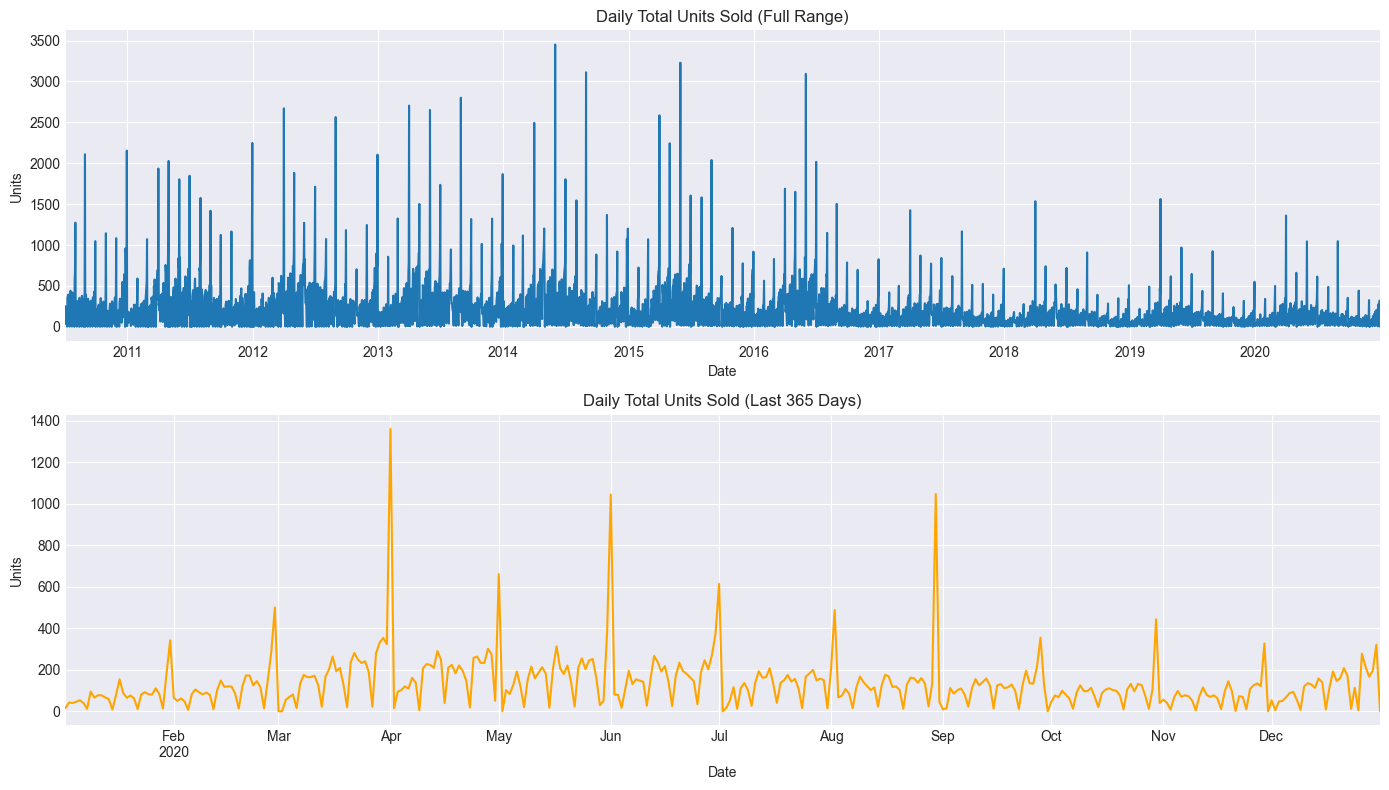

ADF Statistic: -3.2859598542743527
p-value: 0.01551785363848237
Critical value (1%): -3.432070672988693
Critical value (5%): -2.8623002987378547
Critical value (10%): -2.567174716967499


In [18]:
# 4. EDA

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Plot full series
daily["Units"].plot(ax=ax[0])
ax[0].set_title("Daily Total Units Sold (Full Range)")
ax[0].set_ylabel("Units")

# Plot last 365 days for zoomed view
daily["Units"].last("365D").plot(ax=ax[1], color="orange")
ax[1].set_title("Daily Total Units Sold (Last 365 Days)")
ax[1].set_ylabel("Units")

plt.tight_layout()
plt.show()

# ADF stationarity test (on original series)
result = adfuller(daily["Units"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical value ({key}): {value}")


In [20]:
# 5. FEATURE ENGINEERING (CALENDAR FEATURES FOR ANALYSIS / FUTURE SARIMAX)

fe_df = daily.copy()
fe_df["year"] = fe_df.index.year
fe_df["month"] = fe_df.index.month
fe_df["dow"] = fe_df.index.dayofweek  # 0 = Monday
fe_df["week"] = fe_df.index.isocalendar().week.astype(int)




C:\Users\anshu\AppData\Local\Temp\ipykernel_14688\3591242887.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_avg.index, y=dow_avg.values, palette="viridis")


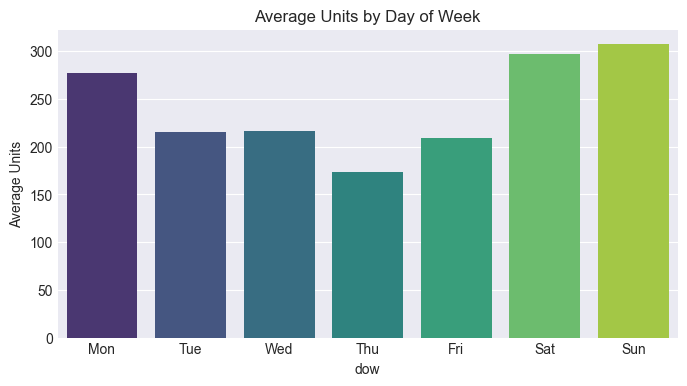

In [21]:
# Average Units per day-of-week (useful to see weekly seasonality)
dow_avg = fe_df.groupby("dow")["Units"].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=dow_avg.index, y=dow_avg.values, palette="viridis")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("Average Units by Day of Week")
plt.ylabel("Average Units")
plt.show()

In [22]:
# 6. TRAIN / VALIDATION SPLIT (TIME-BASED)

# Choose a split date – last 6 months (example)
split_date = "2020-07-01"

train_series = daily.loc[:split_date, "Units"]
val_series   = daily.loc[split_date:, "Units"]

print("Train period:", train_series.index.min(), "to", train_series.index.max())
print("Validation period:", val_series.index.min(), "to", val_series.index.max())
print("Train size:", len(train_series), "Val size:", len(val_series))


Train period: 2010-07-04 00:00:00 to 2020-07-01 00:00:00
Validation period: 2020-07-01 00:00:00 to 2020-12-31 00:00:00
Train size: 3651 Val size: 184


In [23]:
# 7. MODEL SELECTION – SARIMA ORDER VIA auto_arima

season_length = 7  # weekly seasonality for daily data

auto_model = auto_arima(
    train_series,
    seasonal=True,
    m=season_length,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    d=None, D=None,           # let auto_arima infer differencing
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

# Extract best orders
order = auto_model.order
seasonal_order = auto_model.seasonal_order
print("Selected SARIMA order:", order)
print("Selected seasonal order:", seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=51080.624, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=53012.136, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=52215.601, Time=1.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=51071.452, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=53010.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=51148.472, Time=0.59 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=51031.681, Time=3.51 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=50981.836, Time=7.01 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=9.54 sec
 ARIMA(0,1,1)(1,0,3)[7] intercept   : AIC=inf, Time=14.27 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=51029.150, Time=8.63 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=8.75 sec
 ARIMA(0,1,1)(2,0,3)[7] intercept   : AIC=inf, Time=18.65 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=52903

In [24]:
# 8. MODEL TRAINING – FIT SARIMAX ON TRAINING DATA

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_series,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())


                                         SARIMAX Results                                         
Dep. Variable:                                     Units   No. Observations:                 3651
Model:             SARIMAX(0, 1, 2)x(1, 0, [1, 2, 3], 7)   Log Likelihood              -25291.946
Date:                                   Sat, 06 Dec 2025   AIC                          50597.893
Time:                                           16:19:52   BIC                          50641.264
Sample:                                       07-04-2010   HQIC                         50613.343
                                            - 07-01-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8470      0.009    -91.789      0.000    

Validation MAE : 110.63
Validation RMSE: 18,769.14
Validation MAPE (naive) : 570.58%
Validation SMAPE (robust): 78.96%
Validation R²            : -0.6239


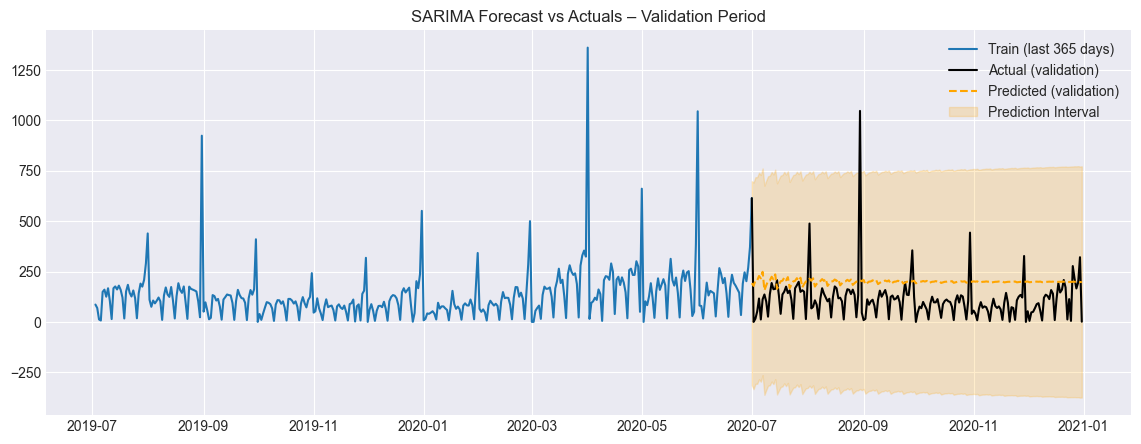

In [29]:
# 9. MODEL EVALUATION / PERFORMANCE (CORRECTED & MORE ROBUST)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

n_val = len(val_series)

forecast_obj = sarima_results.get_forecast(steps=n_val)
val_pred = forecast_obj.predicted_mean
val_ci = forecast_obj.conf_int()

# --- make sure indices align ---
val_pred.index = val_series.index
val_ci.index = val_series.index

y_true = val_series
y_pred = val_pred

# --- core error metrics ---
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)

# MAPE can explode when y_true has zeros or very small values -> handle carefully
denom = y_true.replace(0, np.nan)  # avoid division by 0
mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100

# SMAPE (symmetric MAPE) is more stable with zeros
smape = 100 * np.mean(
    2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
)

# Optional: R² as a sanity check (not always ideal for time series, but informative)
r2 = r2_score(y_true, y_pred)

print(f"Validation MAE : {mae:,.2f}")
print(f"Validation RMSE: {rmse:,.2f}")
print(f"Validation MAPE (naive) : {mape:,.2f}%")
print(f"Validation SMAPE (robust): {smape:,.2f}%")
print(f"Validation R²            : {r2:,.4f}")

# --- Plot actual vs predicted on validation window ---
plt.figure(figsize=(14,5))
plt.plot(train_series[-365:], label="Train (last 365 days)")
plt.plot(y_true, label="Actual (validation)", color="black")
plt.plot(y_pred, label="Predicted (validation)", color="orange", linestyle="--")
plt.fill_between(
    val_ci.index,
    val_ci.iloc[:, 0],
    val_ci.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("SARIMA Forecast vs Actuals – Validation Period")
plt.legend()
plt.show()


c:\Users\anshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast horizon (days): 547


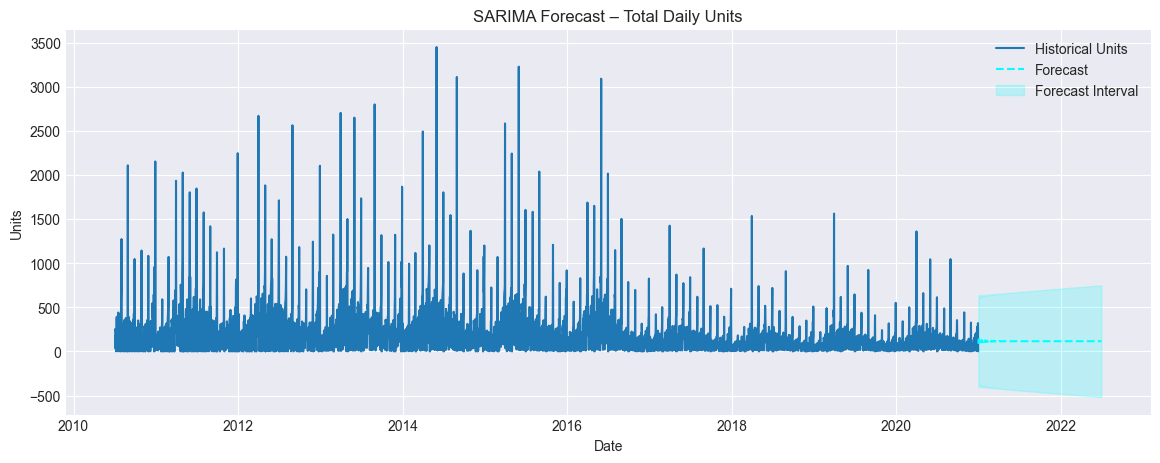

In [27]:
# 10. FINAL FORECASTING GRAPH PLOT (TRAIN + FUTURE)

# 1) Refit SARIMA on full series
full_model = SARIMAX(
    daily["Units"],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# 2) Determine forecast horizon based on test.csv
max_train_date = daily.index.max()
max_test_date = test_df["Date"].max()

forecast_horizon = (max_test_date - max_train_date).days
print("Forecast horizon (days):", forecast_horizon)

# Safety – if horizon <= 0, pick e.g. 90 days
if forecast_horizon <= 0:
    forecast_horizon = 90
    print("Test dates not beyond train – using 90-day demo horizon instead.")

forecast_obj_full = full_model.get_forecast(steps=forecast_horizon)
future_pred = forecast_obj_full.predicted_mean
future_ci = forecast_obj_full.conf_int()

# Build a date index for future forecast
future_index = pd.date_range(
    start=max_train_date + pd.Timedelta(days=1),
    periods=forecast_horizon,
    freq="D"
)
future_pred.index = future_index
future_ci.index = future_index

# 3) Plot: full history + forecast
plt.figure(figsize=(14,5))
plt.plot(daily["Units"], label="Historical Units")
plt.plot(future_pred, label="Forecast", color="cyan", linestyle="--")
plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1],
                 color="cyan", alpha=0.2, label="Forecast Interval")
plt.title("SARIMA Forecast – Total Daily Units")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.show()
